In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler

with open('../../postprocessing/representation.npy', 'rb') as f:
    rep = np.load(f)
    scaler = StandardScaler()
    scaler.fit(rep)
    rep = scaler.transform(rep)
    
print(rep.shape)

(63153, 256)


In [23]:
from sklearn.utils import shuffle
import pandas as pd

NUM_SAMPLES = None

df = pd.read_csv('../../dataset/m_test.csv')
mask = np.logical_or(df['photoz']<0.15, df['z']<0.15)

df = df[mask]
rep = rep[mask]

df = shuffle(df, random_state=0, n_samples=NUM_SAMPLES)
rep = shuffle(rep, random_state=0, n_samples=NUM_SAMPLES)

In [24]:
import umap

#Set seed
SEED = 0

#Plot a single UMAP of x with color c
def create_umap(x, n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        densmap=False,
        random_state=SEED
    )
    u = fit.fit_transform(x);
    
    return np.array(u)

#rep = create_umap(rep, n_neighbors=100, min_dist=1, n_components=16)

In [25]:
from sklearn.cluster import mean_shift, estimate_bandwidth
bandwidth = estimate_bandwidth(rep, quantile=0.05, n_samples=5000)
print(bandwidth)

5.826571766872015


In [ ]:
cluster_centers, labels = mean_shift(rep, bandwidth=bandwidth, cluster_all=True, n_jobs=-1, bin_seeding=False)
df['labels'] = labels
print(len(cluster_centers))

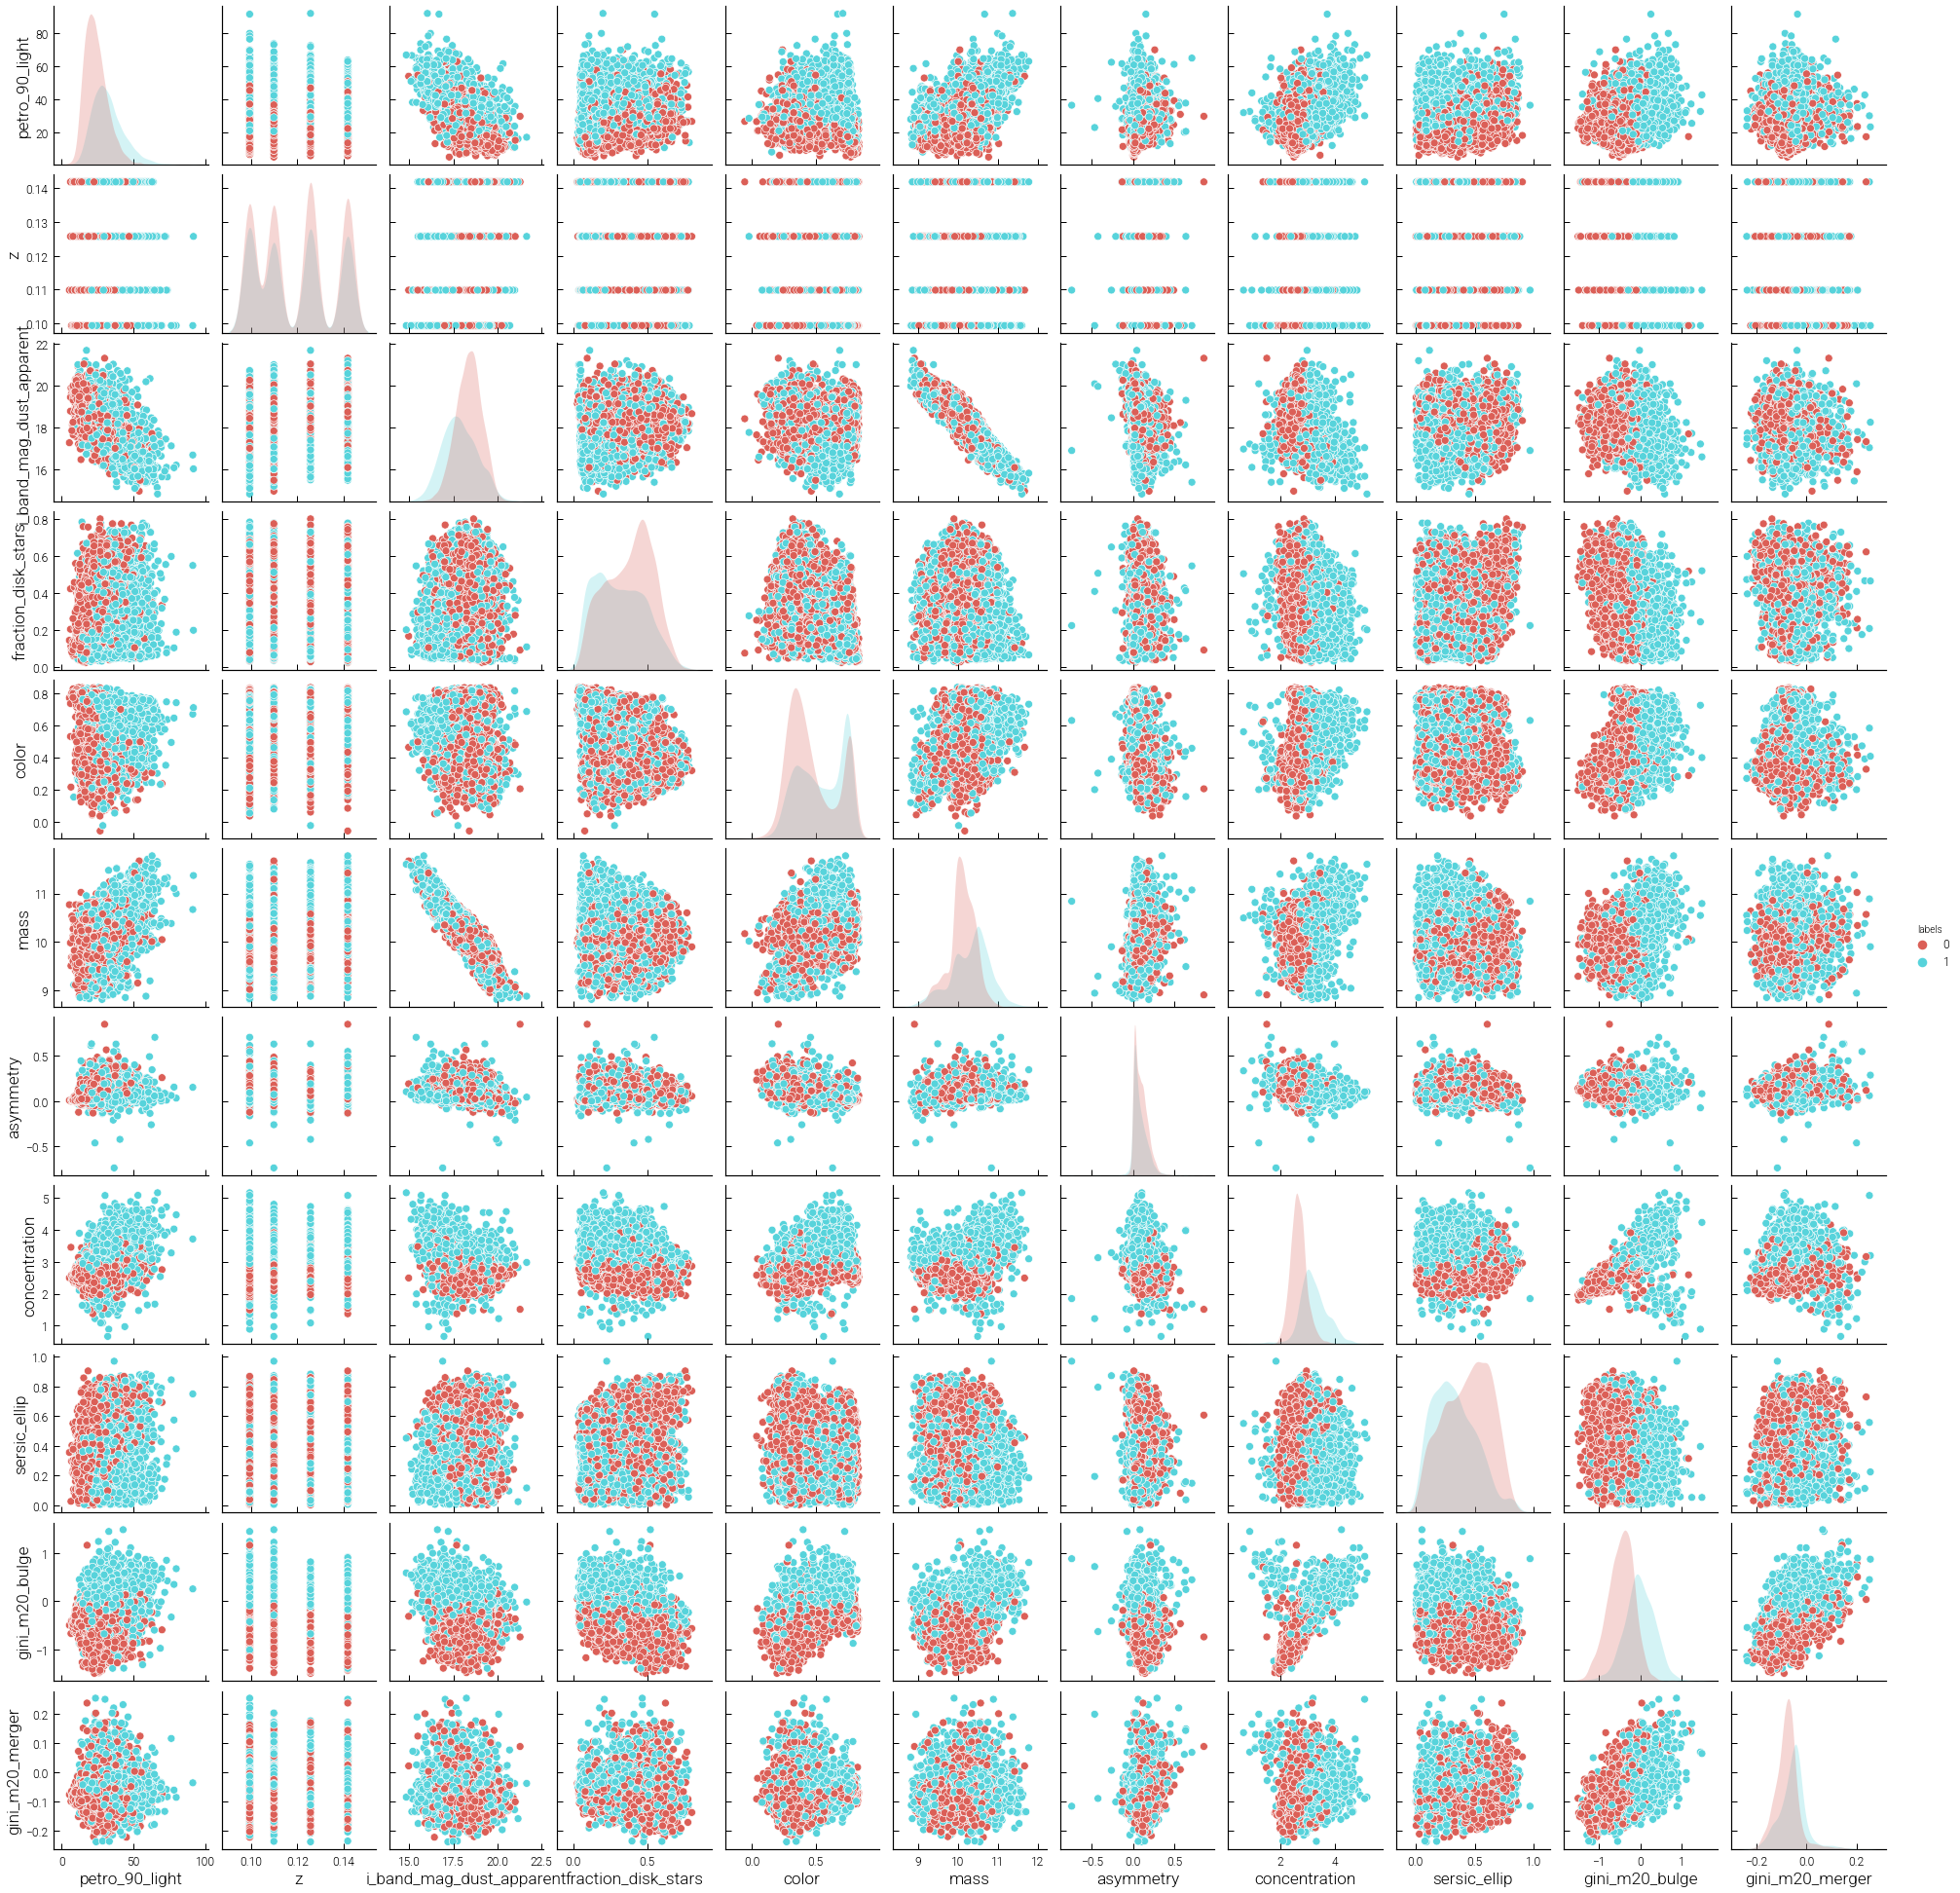

In [19]:
import seaborn as sns

columns = ['labels', 'petro_90_light', 'z', 'i_band_mag_dust_apparent', 'fraction_disk_stars', 'color',  'mass', 'asymmetry', 'concentration', 'sersic_ellip', 'gini_m20_bulge', 'gini_m20_merger']
df_cutout = pd.DataFrame(df, columns=columns)
sns.pairplot(df_cutout, hue="labels", palette=sns.color_palette("hls", len(cluster_centers)))

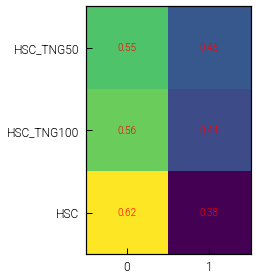

In [20]:
import matplotlib.pyplot as plt

x = np.zeros((len(np.unique(df['dataset'])), len(np.unique(df['labels']))))

for i, d in enumerate(np.unique(df['dataset'])):
    mask = df['dataset'] == d
    num_data = sum(mask)
    for j, l in enumerate(np.unique(df['labels'])):
        x[i,j] = sum(df['labels'][mask] == l)/num_data
        
fig, ax = plt.subplots()
im = ax.imshow(x)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(np.unique(df['dataset']))), labels=np.unique(df['dataset']))
ax.set_xticks(np.arange(len(np.unique(df['labels']))), labels=np.unique(df['labels']))

# Loop over data dimensions and create text annotations.
for i in range(len(np.unique(df['dataset']))):
    for j in range(len(np.unique(df['labels']))):
        text = ax.text(j, i, f'{x[i, j]:.2f}',
                       ha="center", va="center", color="r")



--------------------------------------
0
--------------------------------------


/u/leisert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


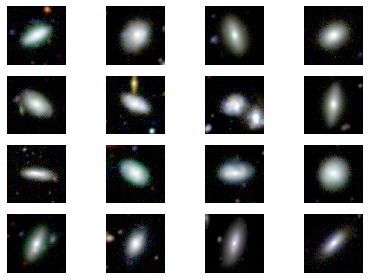

--------------------------------------
1
--------------------------------------


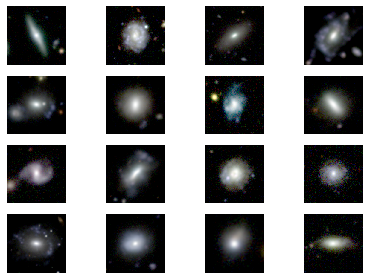

In [21]:
from astropy.io import fits

def load_image(filename):
    
    def get_central_crop(img, num_pixel=20):
        size = img.shape[0]
        center_coordinate = size//2
        upper = center_coordinate + num_pixel//2
        lower = center_coordinate - num_pixel//2
    
        return img[lower:upper, lower:upper]
    
    def stretch(x):
        x[x<=0] = np.nan
        x = np.log10(x)
        x[x<-7] = np.nan
        
        a_min = np.nanmedian(x)
        a_max = np.nanquantile(get_central_crop(x), 0.99)
        
        x = np.nan_to_num(x, nan=a_min, posinf=a_min, neginf=a_min)
        x = np.clip(x, a_min, a_max)
        
        x -= a_min
        x /= (a_max - a_min)
        
        return np.array(x*(2**8 - 1), dtype=np.uint8)
    
    with fits.open(filename) as hdul:
            
        G = hdul['G'].data
        R = hdul['R'].data
        I = hdul['I'].data
            
    G = stretch(G)
    R = stretch(R)
    I = stretch(I)

    return np.concatenate((I[...,np.newaxis],R[...,np.newaxis],G[...,np.newaxis]),axis=2)

for l in np.unique(df['labels']):
    print('--------------------------------------')
    print(l)
    print('--------------------------------------')
    mask = df['labels'] == l
    image_paths = df['image_path'][mask].to_numpy()
    NUM_IMAGES_PER_SIDE = 4
    fig, axes = plt.subplots(NUM_IMAGES_PER_SIDE, NUM_IMAGES_PER_SIDE)
    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
        
            try:
                img = load_image('../.' + image_paths[i + j*NUM_IMAGES_PER_SIDE])
            except FileNotFoundError as e:
                print(e)
                continue
                
            ax = axes[i,j]
            ax.imshow(img)
            ax.axis('off')
            
    plt.show()
    